In [52]:
250306

250306

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Lab 9 - Multi-layer Perceptron Forward Pass & Backpropagation

## Part I
For this exercise you will implement a simple 2-layer perceptron with the forward pass and the backpropagation to learn the weights

For the first part you'll build and train a 2-layer neural network that predicts the prices of houses, using the usual Boston housing dataset.

In [54]:
boston = pd.read_csv('data/housing.csv')

As usual, consider the MEDV as your target variable. 
* Split the data into training, validation and testing (70,15,15)%
* Experiment with different number of neurons per layer for your network, using the validation set

In [55]:
t = boston['MEDV']
boston = boston.drop(['MEDV'], axis=1)

X_train, X_to_split, t_train, t_to_split = train_test_split(boston, t, train_size=.7)
X_validation, X_test, t_validation, t_test = train_test_split(X_to_split, t_to_split, train_size=.5)

X_train = X_train.to_numpy()
X_validation = X_validation.to_numpy()
X_test = X_test.to_numpy()

t_train = t_train.to_numpy()
t_validation = t_validation.to_numpy()
t_test = t_test.to_numpy()

In [56]:
def sigmoid(z: np.ndarray | pd.Series) -> np.ndarray:
    """Sigmoid Function

    Args:
        z (np.ndarray | pd.Series): The vector that we'll apply the sigmoid function
    """
    return 1 / (1 + np.exp(-z))


def d_sigmoid(x: np.ndarray | pd.Series) -> np.ndarray:
    """Sigmoid Derivate Function

    Args:
        z (np.ndarray | pd.Series): Vector that will have the sigmoid applied

    Returns:
        np.ndarray: Derivative applied
    """
    return sigmoid(x) * (1 - sigmoid(x))


def root_mean_squared_error(x: np.ndarray) -> float:
    """Function for calculating the RMSE

    Args:
        x (np.ndarray): Vector for making the RMSE

    Returns:
        float: RMSE
    """
    return np.sqrt(np.sum(x**2)/len(x))


In [57]:
class TwoLayerNeuralNetwork:
    def __init__(self, activation, D, M, K):
        """Implements the forward pass of a two-layer fully connected perceptron.
    
        Parameters
        ----------
        X : a 2-dimensional array
            the input data
        activation : function
            the activation function to be used for the hidden layer
        dim_input : int
            the dimensionality of the input layer
        dim_hidden : int
            the dimensionality of the hidden layer
        dim_output : int
            the dimensionality of the output layer
        Returns
        -------
        y_pred : float
            the output of the computation of the forward pass of the network
        """
        self.activation = activation
        self.dim_input = D
        self.dim_hidden = M
        self.dim_output = K

        self.W_1 = np.random.standard_normal(size=(self.dim_input, self.dim_hidden))
        self.b_1 = np.random.standard_normal(size=(1, self.dim_hidden))
        self.W_2 = np.random.standard_normal(size=(self.dim_hidden, self.dim_output))
        self.b_2 = np.random.standard_normal(size=(1, self.dim_output))
    
    def restart_weights(self):
        self.W_1 = np.random.standard_normal(size=(self.dim_input, self.dim_hidden))
        self.b_1 = np.random.standard_normal(size=(1, self.dim_hidden))
        self.W_2 = np.random.standard_normal(size=(self.dim_hidden, self.dim_output))
        self.b_2 = np.random.standard_normal(size=(1, self.dim_output))
    
    def train(self, X_train: np.ndarray, t_train: np.ndarray, epochs:int=10, learning_rate:float=.0001) -> list:
        """This method trains the network's weights based on the training sets passed

        Args:
            X_train (np.ndarray): The training set
            t_train (np.ndarray): The training target
            epochs (int, optional): Number of epochs to train the model. Defaults to 10.
            learning_rate (float, optional): The learning rate. Defaults to .0001.

        Returns:
            list: List containing the RMSE of the tests for each epoch
        """
        rmses = []  # List of lists of errors, each lists represents an epoch

        for _ in range(epochs):
            for n, x_n in enumerate(X_train):
                x_n = x_n.reshape(1,-1)
                t_n = t_train[n]  # (1, K)  # Getting the wanted output
                
                # Applying the regression on x_n
                y_n = self.activation(x_n @ self.W_1 + self.b_1) @ self.W_2 + self.b_2
                # h( (1xD)(DxM) + (1xM) ) => (1xM)(MxK) + (1xK) => (1xK)

                # Applying the Backpropagation
                z_1 = self.activation(x_n @ self.W_1 + self.b_1)                                   # (1 x M)

                dW_2 = z_1.T @ ((y_n - t_n))                                                       # M x K
                #      (Mx1)       (1xK)
                db_2 = (y_n - t_n)                                                                 # (1xK)

                dW_1 = x_n.T @ ((y_n - t_n) @ self.W_2.T) * d_sigmoid(x_n @ self.W_1 + self.b_1)   # (DxM)
                #      (Dx1)        (1xK)        (KxM)               (1xM)
                db_1 = ((y_n - t_n) @ self.W_2.T) * d_sigmoid(x_n @ self.W_1 + self.b_1)           # (1xM)

                # Backward pass
                self.W_1 = self.W_1 - learning_rate*dW_1
                self.W_2 = self.W_2 - learning_rate*dW_2
                self.b_1 = self.b_1 - learning_rate*db_1
                self.b_2 = self.b_2 - learning_rate*db_2

            y_train = self.activation(X_train @ self.W_1 + self.b_1) @ self.W_2 + self.b_2
            rmses.append(root_mean_squared_error(y_train - t_train))
        
        return rmses

    def fit(self, X):
        return self.activation(X @ self.W_1 + self.b_1) @ self.W_2 + self.b_2

    def validate(
        self,
        X_train: np.ndarray,
        t_train: np.ndarray,
        X_validation: np.ndarray,
        t_validation: np.ndarray,
        max_layers_number: int = 10
    ):
        """Function that updates the hyperparameters of our network. IMPORTANT: It updates the hyperparameters
        but it doesn't retrain our network, that means, if this function finds out that the best number of
        layers is 6 and we first trained it with 8, it won't update our layer to have 6 outputs, you'll need
        to retrain it

        Args:
            X_train (np.ndarray): Train set
            t_train (np.ndarray): Train target
            X_validation (np.ndarray): Validation set
            t_validation (np.ndarray): Validation target
            max_layers_number (int, optional): Maximum amount of layers to test. Defaults to 10.
        """
        rmse_history = []

        for numbers_layer in range(max_layers_number):
            self.dim_hidden = numbers_layer
            self.restart_weights()
            self.train(X_train, t_train)

            y_validation = self.fit(X_validation)
            rmse_history.append(root_mean_squared_error(y_validation - t_validation))
        
        self.dim_hidden = rmse_history.index(min(rmse_history))
        self.restart_weights()

        self.train(np.r_[X_train, X_validation], np.r_[t_train, t_validation])

In [58]:
epochs = 100
model = TwoLayerNeuralNetwork(sigmoid, X_train.shape[1], 8, 1)
rmses = model.train(X_train, t_train, epochs)

Now, let's check the model's RMSE passing the epochs

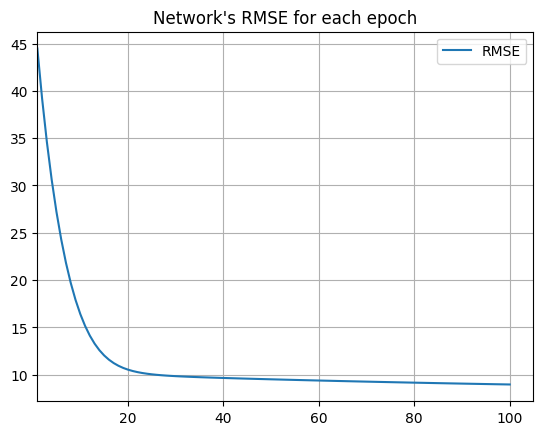

In [59]:
plt.title("Network's RMSE for each epoch")

plt.plot([x+1 for x in range(epochs)], rmses, label="RMSE")

plt.xlim(left=1)

plt.grid()
plt.legend()
plt.show()

Let's check our RMSE with this trained model

In [60]:
y_test = model.fit(X_test)
root_mean_squared_error(y_test - t_test)

np.float64(4.314850706111164)

But we still need to look for the best hyperparameters, so, let's validate our network and check the new RMSE

In [61]:
model.validate(X_train, t_train, X_validation, t_validation, 12)

# Checking the new RMSE
y_test = model.fit(X_test)
root_mean_squared_error(y_test - t_test)

np.float64(4.994883234666671)

## Part II 

For this exercise you will build and train a 2-layer neural network that predicts the exact digit from a hand-written image, using the MNIST dataset. 
For this exercise, add weight decay to your network.

In [62]:
from sklearn.datasets import load_digits

In [63]:
digits = load_digits()

In [64]:
X = digits.data
t = digits.target

In [65]:
X.shape

(1797, 64)

Again, you will split the data into training, validation and testing.

In [ ]:
X_train, X_to_split, t_train, t_to_split = train_test_split(X, t, train_size=.7)
X_validation, X_test, t_validation, t_test = train_test_split(X_to_split, t_to_split, train_size=.5)

t_train = t_train.reshape(-1, 1)
t_validation = t_validation.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

X_train = (X_train - X_train.mean()) / X_train.std()
X_validation = (X_validation - X_train.mean()) / X_train.std()
X_test  = (X_test  - X_train.mean()) / X_train.std()

In [114]:
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return (x > 0).astype(float)

In [ ]:
def soft_max(a_k: np.ndarray) -> np.ndarray:
    # a_k shape = (n_samples, n_classes)
    exp_values = np.exp(a_k - np.max(a_k, axis=1, keepdims=True))  # estabilidade numérica
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

In [68]:
def cross_entropy(y, t):
    return -np.mean(np.sum(t * np.log(y+1e-10), axis=1))